## Watch Your Speed Program (WYSP) - Driver Feedback Sign # 627 in School Safety Zone

## Notebook 2 - Data transformation, model training and evaluation

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

### Load the training and test sets

In [2]:
# Read the training set

train_set = pd.read_csv('data_wysp/train_set.csv', index_col=0)
print(train_set.shape)
train_set.head()

(7956, 4)


,hour,day_of_week,month,over_40
3769,13,5,6,139
6458,12,6,9,137
3638,2,0,6,12
8069,18,3,12,145
3398,18,3,5,154


In [3]:
# Read the test set

test_set = pd.read_csv('data_wysp/test_set.csv', index_col=0)
print(test_set.shape)
test_set.head()

(1990, 4)


,hour,day_of_week,month,over_40
6590,0,5,10,15
4300,16,6,6,130
9773,18,4,2,122
5041,13,2,7,140
4351,19,1,7,73


In [4]:
# Separate the predictors and the labels in the training and test sets

X_train = train_set.drop('over_40', axis=1)
y_train = train_set['over_40'].copy()

X_test = test_set.drop('over_40', axis=1)
y_test = test_set['over_40'].copy()

print(X_train.shape)
print(X_test.shape)

(7956, 3)
(1990, 3)


### One-hot encoding of categorical attributes

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [6]:
# Categorical attributes
cat_attribs = ['hour', 'day_of_week', 'month']

# Create a pipeline for transforming categorical attributes using OneHotEncoder
pipeline = ColumnTransformer([
        ('cat', OneHotEncoder(), cat_attribs),
    ])

In [7]:
# Apply the transformations

X_train_prepared = pipeline.fit_transform(X_train)
print(X_train_prepared.shape)

X_test_prepared = pipeline.transform(X_test)
print(X_test_prepared.shape)

(7956, 43)
(1990, 43)


## Training Different Regression Models

### Linear Regression Model

In [8]:
# Train a Linear Regression model

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
# Function to evaluate the model and compute the RMSE

from sklearn.metrics import mean_squared_error

def compute_rmse(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [10]:
# Training error (RMSE) for the Linear Regression model

lin_rmse = compute_rmse(lin_reg, X_train_prepared, y_train)
lin_rmse

23.261613643275805

In [11]:
# Function to display the cross-validation scores

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [12]:
# Evaluation using cross-validation

from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, X_train_prepared, y_train, 
                             scoring="neg_mean_squared_error", cv=5)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [23.93456971 22.81244319 23.14480958 23.52923477 23.63216274]
Mean: 23.410643999238772
Standard deviation: 0.3914446627437074


### Lasso Regression Model

In [13]:
# GridSearchCV for the Lasso Regression model

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_reg = Lasso(tol=0.05, random_state=42)

param_grid = [{'alpha': [0.001, 0.01, 0.1, 1, 10]}]

grid_search_lasso = GridSearchCV(lasso_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_lasso.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=42,
                             selection='cyclic', tol=0.05, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [14]:
# The best parameter and the corresponding mean RMSE score (for cross-validation)

print(grid_search_lasso.best_params_)
print(np.sqrt(-grid_search_lasso.best_score_))

{'alpha': 0.01}
23.41343018399424


In [15]:
# The best Lasso model
best_lasso = grid_search_lasso.best_estimator_

# Training error
lasso_rmse = compute_rmse(best_lasso, X_train_prepared, y_train)
print(lasso_rmse)

23.262807188153584


The training and cross-validation RMSEs for Lasso Regression (alpha=0.01) are almost the same as the corresponding results for Linear Regression.

### Ridge Regression Model

In [16]:
# GridSearchCV for the Ridge Regression model

from sklearn.linear_model import Ridge

ridge_reg = Ridge(random_state=42)

param_grid = [{'alpha': [0.001, 0.01, 0.1, 1, 10]}]

grid_search_ridge = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_ridge.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=42,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [17]:
# The best parameter and the corresponding mean RMSE score (for cross-validation)

print(grid_search_ridge.best_params_)
print(np.sqrt(-grid_search_ridge.best_score_))

{'alpha': 0.1}
23.413630222120528


In [18]:
# The best Ridge model
best_ridge = grid_search_ridge.best_estimator_

# Training error
ridge_rmse = compute_rmse(best_ridge, X_train_prepared, y_train)
print(ridge_rmse)

23.26162121735754


The training and cross-validation RMSEs for Ridge Regression (alpha=0.1) are almost the same as the corresponding results for Linear Regression.

### Polynomial Regression Model (degree=2)

In [19]:
# Polynomial Regression (degree=2)

from sklearn.preprocessing import PolynomialFeatures

poly_features= PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_prepared)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
# Training error

poly_rmse = compute_rmse(poly_reg, poly_features.transform(X_train_prepared), y_train)
print(poly_rmse)

17.414330190004154


In [21]:
# Evaluation using cross-validation

poly_scores = cross_val_score(poly_reg, X_train_poly, y_train,
                              scoring="neg_mean_squared_error", cv=5)

poly_rmse_scores = np.sqrt(-poly_scores)
display_scores(poly_rmse_scores)

Scores: [19.18824642 17.96383187 18.48036291 19.29456355 18.26592065]
Mean: 18.638585080730927
Standard deviation: 0.5199308147062408


The training and cross-validation RMSEs for Polynomial Regression (degree=2) are lower than the corresponding errors for Linear Regression.

### Linear SVM Regression

In [22]:
# Linear SVM Regression

from sklearn.svm import LinearSVR

svm_reg = LinearSVR(random_state=42)
svm_reg.fit(X_train_prepared, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [23]:
# Training error

svm_rmse = compute_rmse(svm_reg, X_train_prepared, y_train)
print(svm_rmse)

23.919531677174493


In [24]:
# Evaluation using cross-validation

svm_scores = cross_val_score(svm_reg, X_train_prepared, y_train,
                             scoring="neg_mean_squared_error", cv=5)

svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [24.15478999 23.70870846 24.35711295 24.17734697 24.48095648]
Mean: 24.17578297199417
Standard deviation: 0.2625312120956695


The results are slightly worse than the results for the Linear Regression model.

### SVM Regression using a second-degree polynomial kernel

In [25]:
# SVM Regression using a second-degree polynomial kernel

from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(X_train_prepared, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [26]:
# Training error

svm_poly_rmse = compute_rmse(svm_poly_reg, X_train_prepared, y_train)
print(svm_poly_rmse)

26.728868418204488


In [27]:
# Evaluation using cross-validation

svm_poly_scores = cross_val_score(svm_poly_reg, X_train_prepared, y_train,
                                  scoring="neg_mean_squared_error", cv=5)

svm_poly_rmse_scores = np.sqrt(-svm_poly_scores)
display_scores(svm_poly_rmse_scores)

Scores: [29.80778118 29.7805617  30.92374316 28.42543211 29.55228809]
Mean: 29.697961247404145
Standard deviation: 0.795232749826088


The RMSE values are larger than the errors for the previous models.

### XGBoost Regression Model

In [28]:
# XGBRegressor with standard hyperparameters

from xgboost.sklearn import XGBRegressor

xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train_prepared, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [29]:
# Training error

xgb_rmse = compute_rmse(xgb_reg, X_train_prepared, y_train)
xgb_rmse

23.313683831571765

In [30]:
# Cross-validation

xgb_scores = cross_val_score(xgb_reg, X_train_prepared, y_train, 
                             scoring="neg_mean_squared_error", cv=5)

xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

Scores: [23.8497062  23.48111302 23.22468086 23.51932096 23.63233642]
Mean: 23.54143149288155
Standard deviation: 0.20384070196159482


The results for the XGBoost Regression are very close to the results for the Linear Regression model.

### Random Forest Regression Model

In [31]:
# Random Forest Regressor with standard hyperparameters

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train_prepared, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [32]:
# Training error

forest_rmse = compute_rmse(forest_reg, X_train_prepared, y_train)
print(forest_rmse)

15.900884440550868


In [33]:
# Cross-validation

forest_scores = cross_val_score(forest_reg, X_train_prepared, y_train,
                                scoring="neg_mean_squared_error", cv=5)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [21.85699732 20.05412815 20.55477718 22.21478655 20.28883301]
Mean: 20.99390444187859
Standard deviation: 0.8727680577345062


The cross-validation RMSE (20.99) is smaller than the corresponding values for most other models (only the polynomyal regression model showed better result - 18.64).

The error on the training set (15.90) is much lower than on the validation sets (20.99), this random forest model is overfitting the training set. 

Next, I will try to regularize the model using the 'min_samples_leaf' hyperparameter.


### Tune the Random Forest model:

In [34]:
# Tuning the Random Forest using grid search

param_grid_rf = [
    {'n_estimators': [50, 100, 150, 200, 250], 'min_samples_leaf': [4, 6, 8, 10, 12]}
  ]

rf_reg = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(rf_reg, param_grid_rf, cv=5,
                              scoring='neg_mean_squared_error', 
                              return_train_score=True)

grid_search_rf.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [35]:
# The best parameters

grid_search_rf.best_params_

{'min_samples_leaf': 6, 'n_estimators': 200}

In [36]:
# The combinations of the RMSEs and parameters
# For the parameters {'min_samples_leaf': 6, 'n_estimators': 200}: the RMSE is approximately 19.00

cvres = grid_search_rf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

19.079382505081607 {'min_samples_leaf': 4, 'n_estimators': 50}
19.03990108585652 {'min_samples_leaf': 4, 'n_estimators': 100}
19.03388785056463 {'min_samples_leaf': 4, 'n_estimators': 150}
19.030274165260064 {'min_samples_leaf': 4, 'n_estimators': 200}
19.030959848797615 {'min_samples_leaf': 4, 'n_estimators': 250}
19.046525120720435 {'min_samples_leaf': 6, 'n_estimators': 50}
19.007987167876433 {'min_samples_leaf': 6, 'n_estimators': 100}
19.008238195495505 {'min_samples_leaf': 6, 'n_estimators': 150}
19.004340025419786 {'min_samples_leaf': 6, 'n_estimators': 200}
19.00634239086071 {'min_samples_leaf': 6, 'n_estimators': 250}
19.122425580233774 {'min_samples_leaf': 8, 'n_estimators': 50}
19.087963224127755 {'min_samples_leaf': 8, 'n_estimators': 100}
19.090999659559834 {'min_samples_leaf': 8, 'n_estimators': 150}
19.09186781028765 {'min_samples_leaf': 8, 'n_estimators': 200}
19.08926719583649 {'min_samples_leaf': 8, 'n_estimators': 250}
19.286543070431765 {'min_samples_leaf': 10, 'n_e

In [37]:
# Feature importances

feature_importances = grid_search_rf.best_estimator_.feature_importances_
feature_importances

array([0.06848618, 0.06834473, 0.06761633, 0.06667225, 0.06724722,
       0.06866159, 0.05509263, 0.01846988, 0.01102979, 0.00590171,
       0.00366679, 0.00108589, 0.00161279, 0.00130315, 0.00111073,
       0.00197664, 0.08684331, 0.0977613 , 0.00615987, 0.01301732,
       0.0282773 , 0.04432329, 0.05591351, 0.06303166, 0.03649072,
       0.00357041, 0.00096109, 0.0015674 , 0.00209799, 0.00448191,
       0.02473764, 0.004029  , 0.00314549, 0.00054812, 0.0036569 ,
       0.00153328, 0.00167038, 0.00110422, 0.00244202, 0.00084706,
       0.00046773, 0.0009091 , 0.00213367])

In [38]:
# Get the names of the features
# The order of the OneHotEncoder categories: 'hour' categories, 'day_of_week' categories, 'month' categories

cat_encoder = pipeline.named_transformers_['cat']
attributes = cat_encoder.get_feature_names(['hour', 'day', 'month'])
attributes

array(['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'], dtype=object)

In [39]:
# Sorted feature importances

sorted(zip(feature_importances, attributes), reverse=True)

[(0.09776130465956742, 'hour_17'),
 (0.08684331489668234, 'hour_16'),
 (0.06866158925228412, 'hour_5'),
 (0.0684861830966426, 'hour_0'),
 (0.0683447298009628, 'hour_1'),
 (0.0676163258002689, 'hour_2'),
 (0.06724722080291025, 'hour_4'),
 (0.06667225450172239, 'hour_3'),
 (0.06303166218025938, 'hour_23'),
 (0.05591350545127864, 'hour_22'),
 (0.05509263472042309, 'hour_6'),
 (0.04432328851912717, 'hour_21'),
 (0.03649071733797256, 'day_0'),
 (0.028277304981650486, 'hour_20'),
 (0.024737644308281986, 'day_6'),
 (0.018469875377937515, 'hour_7'),
 (0.013017319934451248, 'hour_19'),
 (0.011029790282930482, 'hour_8'),
 (0.0061598712574851165, 'hour_18'),
 (0.005901707151658853, 'hour_9'),
 (0.0044819065959154835, 'day_5'),
 (0.004028997632055776, 'month_1'),
 (0.0036667940954070283, 'hour_10'),
 (0.0036568962260634975, 'month_4'),
 (0.0035704127591010765, 'day_1'),
 (0.0031454904146099283, 'month_2'),
 (0.0024420155977484285, 'month_8'),
 (0.002133667697681742, 'month_12'),
 (0.00209799200333

In [40]:
# The best Random Forest model

best_rf = grid_search_rf.best_estimator_

In [41]:
# Training error

rf_rmse = compute_rmse(best_rf, X_train_prepared, y_train)
print(rf_rmse)

17.588159600968634


After tuning the random forest model, the scores for the training set and validation sets are much closer (17.59 and 19.00 respectively). These results are better than the results for most other models and are comparable with the scores for the Polynomial Regression (17.41 for the whole training set and 18.64 for cross-validation).

The following models showed the best performance: **Polynomial Regression (degree=2)** and **Random Forest Regression (n_estimators=200, min_samples_leaf=6)**

## Evaluate two best models on the test set

### Polynomial Regression generalization error

In [42]:
# Test error

poly_test_pred = poly_reg.predict(poly_features.transform(X_test_prepared))
poly_test_mse = mean_squared_error(y_test, poly_test_pred)
poly_test_rmse = np.sqrt(poly_test_mse)
poly_test_rmse

18.946873443155226

In [43]:
# 95% Confidence interval for the test RMSE

from scipy import stats

confidence = 0.95
squared_errors = (poly_test_pred - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([17.45772683, 20.32721822])

In [44]:
# NRMSE
# The estimates are off by an average of 24.9%

poly_test_nrmse = poly_test_rmse / y_test.mean()
poly_test_nrmse

0.24866303157648256

### Random Forest Regression generalization error

In [45]:
# Test error

rf_test_pred = best_rf.predict(X_test_prepared)
rf_test_mse = mean_squared_error(y_test, rf_test_pred)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_test_rmse

19.348793111044774

In [46]:
# 95% Confidence interval for the test RMSE

confidence = 0.95
squared_errors = (rf_test_pred - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([17.84880685, 20.7405806 ])

In [47]:
# NRMSE
# The estimates are off by an average of 25.4%

rf_test_nrmse = rf_test_rmse / y_test.mean()
rf_test_nrmse

0.2539379157608034

**The results for two models are close. The Polynomial Regression Model performed slightly better, it can be chosen as a final model.**

## Full pipeline for the Polynomial Regression model

In [48]:
# Full pipeline (including encoding and model)

polynomial_regression = Pipeline([
        ('encoder', OneHotEncoder()),
        ('poly_features', PolynomialFeatures(degree=2)),
        ('lin_reg', LinearRegression())
    ])

polynomial_regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('encoder',
                 OneHotEncoder(categories='auto', drop=None,
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='error', sparse=True)),
                ('poly_features',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

### Predictions - Example

**Predict hourly counts of vehicles in the speed bin "40 km/hr and higher" for November 6, 2020 (if city traffic is back to normal)**

In [49]:
# Create input data: all hour values (from 0 to 23), Friday (value=5), October (value=11)

data = pd.DataFrame({'hour': np.arange(24)})
data['day_of_week'] = 5
data['month'] = 11
data.head()

,hour,day_of_week,month
0,0,5,11
1,1,5,11
2,2,5,11
3,3,5,11
4,4,5,11


In [50]:
# Predict the 'over_40' values using full pipeline

predictions = polynomial_regression.predict(data)
predictions

array([ 17.06497831,  10.18475671,   6.92458135,   6.00039795,
         5.13635666,  22.21059567,  45.30920494, 103.22462927,
       153.42599145, 114.12004897, 127.89567124, 145.52543633,
       144.26587177, 138.11340227, 136.38974616, 139.02924801,
       172.26961877, 175.16084924, 136.89602438,  97.35945128,
        74.29409191,  60.22854153,  42.71855303,  35.11288854])

In [51]:
# DataFrame  with predictions

data_pred = data.copy()
data_pred['over_40'] = np.round(predictions).astype(int)
data_pred

,hour,day_of_week,month,over_40
0,0,5,11,17
1,1,5,11,10
2,2,5,11,7
3,3,5,11,6
4,4,5,11,5
5,5,5,11,22
6,6,5,11,45
7,7,5,11,103
8,8,5,11,153
9,9,5,11,114


Text(0, 0.5, 'over_40')

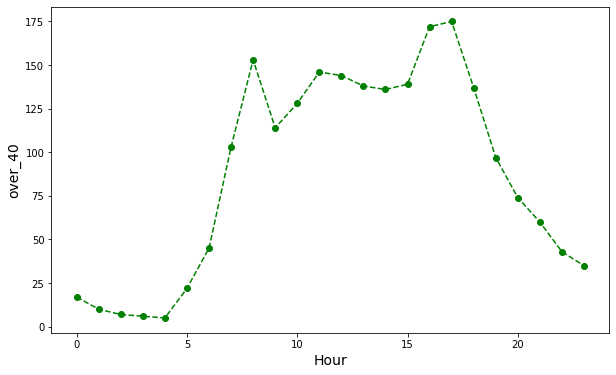

In [52]:
# Plot predictions

plt.rc('figure', figsize=(10, 6))

plt.plot(data_pred['hour'], data_pred['over_40'], 'go--')

plt.xlabel('Hour', size=14)
plt.ylabel('over_40', size=14)

There are peaks in the predicted 'over_40' vehicle counts for this day: between 8am and 9am, and between 4pm and 6pm.